In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector, TimeDistributed
from unicodedata import normalize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical

from numpy import array
import pickle
#from keras.utils.vis_utils import plot_model


from nltk.corpus import stopwords
import string
import re

import matplotlib.pyplot as plt
%matplotlib inline

## Language Translator

In [2]:
import nltk

From `nltk` we can download translated sentences between different languages. You can see the example between **English and French** below but feel free to try different combination as well.

In [3]:
nltk.download('comtrans')

[nltk_data] Downloading package comtrans to /home/aj/nltk_data...
[nltk_data]   Package comtrans is already up-to-date!


True

In [4]:
from nltk.corpus import comtrans
print(comtrans.aligned_sents('alignment-en-fr.txt')[0])

<AlignedSent: 'Resumption of the se...' -> 'Reprise de la sessio...'>


In [5]:
len(comtrans.aligned_sents('alignment-en-fr.txt'))

33334

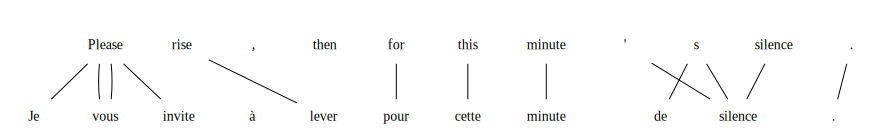

In [20]:
comtrans.aligned_sents('alignment-en-fr.txt')[3]

In [ ]:
print(comtrans.aligned_sents('alignment-en-fr.txt')[2].words)
print(comtrans.aligned_sents('alignment-en-fr.txt')[2].mots)
print(comtrans.aligned_sents('alignment-en-fr.txt')[2].alignment)

['You', 'have', 'requested', 'a', 'debate', 'on', 'this', 'subject', 'in', 'the', 'course', 'of', 'the', 'next', 'few', 'days', ',', 'during', 'this', 'part-session', '.']
['Vous', 'avez', 'souhaité', 'un', 'débat', 'à', 'ce', 'sujet', 'dans', 'les', 'prochains', 'jours', ',', 'au', 'cours', 'de', 'cette', 'période', 'de', 'session', '.']
0-0 0-1 1-1 2-2 3-3 4-4 5-5 6-6 7-7 8-8 9-9 10-10 13-10 14-10 15-11 16-12 17-13 17-14 18-16 19-17 19-18 19-19 20-20


In [ ]:
dataset = comtrans.aligned_sents('alignment-en-fr.txt')

In [2]:
def retrieve_corpora(corpora):
    print("Retrieving corpora: {}".format(corpora))
    als = comtrans.aligned_sents(corpora)
    eng_sen = [sent.words for sent in als]
    fre_sen = [sent.mots for sent in als]
    return [eng_sen, fre_sen]

In [ ]:
dataset = retrieve_corpora('alignment-en-fr.txt')

Retrieving corpora: alignment-en-fr.txt


In [ ]:
pickle.dump(dataset, open('dataset.txt', 'wb'))

In [22]:
dataset = pickle.load(open('dataset.txt', 'rb'))

In [23]:
text1 = dataset[0]

In [24]:
text2 = dataset[1]

In [25]:
print("English:", text1[0])
print("French:", text2[0])
print("# Corpora length (i.e. number of sentences)")
print(len(text2))

English: ['Resumption', 'of', 'the', 'session']
French: ['Reprise', 'de', 'la', 'session']
# Corpora length (i.e. number of sentences)
33334


In [26]:
def clean_sentence(sentence):
    regex_splitter = re.compile('[^%s]' % re.escape(string.printable))
    clean_words = [re.split(regex_splitter, word.lower()) for word in sentence]
    return [w for words in clean_words for w in words if words if w]

In [27]:
clean_text1 = [clean_sentence(s) for s in text1]
clean_text2 = [clean_sentence(s) for s in text2]
print("English:", clean_text1[0])
print("French:", clean_text2[0])

English: ['resumption', 'of', 'the', 'session']
French: ['reprise', 'de', 'la', 'session']


In [30]:
def filter_text(text1, text2, min_len=0, max_len=20):
    filtered1 = []
    filtered2 = []
    for i in range(len(text1)):
        if min_len <= len(text1[i]) <= max_len and min_len <= len(text2[i]) <= max_len:
            filtered1.append(text1[i])
            filtered2.append(text2[i])
    return filtered1, filtered2

In [31]:
filter_text1, filter_text2 = filter_text(clean_text1, clean_text2)
print("# Filtered Corpora length (i.e. number of sentences)")
print(len(filter_text1))
assert len(filter_text1) == len(filter_text2)

# Filtered Corpora length (i.e. number of sentences)
12861


Tokenize

In [34]:
# max sentence length
def max_length(lines):
    return max(len(line) for line in lines)

In [142]:
max_length(filter_text1)

30

In [32]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [35]:
# prepare english tokenizer
eng_tokenizer = create_tokenizer(filter_text1)
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(filter_text1)
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))

# prepare french tokenizer
fre_tokenizer = create_tokenizer(filter_text2)
fre_vocab_size = len(fre_tokenizer.word_index) + 1
fre_length = max_length(filter_text2)
print('French Vocabulary Size: %d' % fre_vocab_size)
print('French Max Length: %d' % (fre_length))

English Vocabulary Size: 8783
English Max Length: 20
French Vocabulary Size: 10264
French Max Length: 20


In [147]:
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X

In [68]:
# one hot encode target sequence
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

In [148]:
trainX = encode_sequences(fre_tokenizer, fre_length, filt_clean_sen_l1[:1000])
trainY = encode_sequences(eng_tokenizer, eng_length, filt_clean_sen_l2[:1000])
trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
testX = encode_sequences(fre_tokenizer, fre_length, filt_clean_sen_l1[1000:1200])
testY = encode_sequences(eng_tokenizer, eng_length, filt_clean_sen_l2[1000:1200])
testY = encode_output(testY, eng_vocab_size)

In [ ]:
testX

In [73]:
#Create model
def create_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(TimeDistributed(Dense(out_vocab, activation='softmax')))
    return model

model = create_model(fre_vocab_size, eng_vocab_size, fre_length, eng_length, 256)

#Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 256)           2627584   
_________________________________________________________________
lstm_6 (LSTM)                (None, 256)               525312    
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 20, 256)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 20, 256)           525312    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 8783)          2257231   
Total params: 5,935,439
Trainable params: 5,935,439
Non-trainable params: 0
_________________________________________________________________
None


In [149]:
# define model
model = define_model(fre_vocab_size, eng_vocab_size, fre_length, eng_length, 256)

In [150]:

#RMS is good optimizer for RNNs
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy')
# summarize defined model

In [152]:
print(model.summary())
#plot_model(model, to_file='model.png', show_shapes=True)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 256)           3963136   
_________________________________________________________________
lstm_8 (LSTM)                (None, 256)               525312    
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 30, 256)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 30, 256)           525312    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 13308)         3420156   
Total params: 8,433,916
Trainable params: 8,433,916
Non-trainable params: 0
_________________________________________________________________
None


In [167]:
# fit model
filename = 'model'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

model.fit(trainX, trainY, epochs=5, batch_size=128, validation_split = 0.2, callbacks=[checkpoint], verbose=1)

Epoch 1/5
7/7 [==============================] - 21s 3s/step - loss: 1.2807 - val_loss: 1.5146

Epoch 00001: val_loss improved from inf to 1.51464, saving model to model


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


Epoch 2/5
7/7 [==============================] - 20s 3s/step - loss: 1.2680 - val_loss: 1.4944

Epoch 00002: val_loss improved from 1.51464 to 1.49443, saving model to model


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


Epoch 3/5
7/7 [==============================] - 20s 3s/step - loss: 1.2459 - val_loss: 1.5002

Epoch 00003: val_loss did not improve from 1.49443
Epoch 4/5
7/7 [==============================] - 20s 3s/step - loss: 1.2426 - val_loss: 1.4962

Epoch 00004: val_loss did not improve from 1.49443
Epoch 5/5
7/7 [==============================] - 20s 3s/step - loss: 1.2342 - val_loss: 1.4892

Epoch 00005: val_loss improved from 1.49443 to 1.48915, saving model to model


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [40]:
preds = model.predict(testX)

NameError: name 'model' is not defined

In [170]:
preds = model.predict_classes(testX,verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 1s 206ms/step


In [171]:
preds[5]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [126]:
testX[1]

array([1094,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [122]:
#function to return array to words
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [123]:
#init predictions
preds_text = []

for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None): 
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))

ValueError: ignored

In [39]:
text1[100]

['I',
 'think',
 'this',
 'is',
 'a',
 'better',
 'solution',
 'than',
 'proceeding',
 'now',
 'to',
 'extremely',
 'time-consuming',
 'explanations',
 'of',
 'votes',
 '.']

In [89]:
preds_text[100]

'                   '

In [32]:
def evaluate_model(model, tokenizer, sources, raw_dataset):
	actual, predicted = list(), list()
	for i, source in enumerate(sources):
		# translate encoded source text
		source = source.reshape((1, source.shape[0]))
		translation = predict_sequence(model, eng_tokenizer, source)
		raw_target = raw_dataset[i]
		actual.append([raw_target.split()])
		predicted.append(translation.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [33]:
evaluate_model(model, eng_tokenizer, testX, dataset[0])

AttributeError: ignored

In [29]:
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

In [42]:
word_for_id(5, eng_tokenizer)

'is'

In [27]:
from numpy import argmax

In [25]:
# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)

In [ ]:
evaluate_model(model, eng_tokenizer, X, filt_clean_sen_l2)

NameError: name 'evaluate_model' is not defined

In [ ]:
predict_sequence(model, eng_tokenizer, filt_clean_sen_l1)

NameError: ignored